## This file is how World Sentiment was constructed with some additional context

Imports

In [ ]:
from datetime import datetime, timedelta
import time
import pandas as pd
import trafilatura
from gdeltdoc import GdeltDoc, Filters
import requests
import zipfile
import io
import re
from trafilatura import fetch_url, extract_metadata
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt



This is how the GDELT News articles were pulled. Run this over specified data ranges

In [ ]:

# --- CRYPTO / BITCOIN TOPICS ---
topics = [
    "bitcoin",
    "cryptocurrency",
    "crypto market",
    "bitcoin price",
    "crypto regulation",
    "bitcoin etf",
]

# --- TRUSTED SOURCES ---
trusted_sources = [
    # General News
    "bbc.com", "reuters.com", "apnews.com", "npr.org", "aljazeera.com",
    "theguardian.com", "abcnews.go.com", "cbsnews.com", "nbcnews.com",
    "usatoday.com", "yahoo.com", "voiceofamerica.com", "dw.com", "newsweek.com",
    "news.com.au", "scmp.com", "japantimes.co.jp",

    # Tech News
    "techcrunch.com", "theverge.com", "arstechnica.com", "wired.com",
    "engadget.com", "gizmodo.com", "venturebeat.com", "mashable.com",
    "zdnet.com", "slashdot.org", "cnet.com","techradar.com", "digitaltrends.com",
    "tomshardware.com", "pcmag.com", "androidauthority.com", "thenextweb.com",

    # Crypto-Native
    "coindesk.com", "cointelegraph.com", "cryptonews.com", "decrypt.co",
    "theblock.co", "beincrypto.com", "bitcoinmagazine.com", "cryptopotato.com",
    "u.today", "ambcrypto.com", "cryptobriefing.com", "cryptoslate.com",
    "bitcoinist.com", "btcmanager.com", "cryptonewsz.com",


    # Finance/Economics
    "investing.com", "marketwatch.com", "finance.yahoo.com",
    "fool.com", "seekingalpha.com", "fxstreet.com", "cnbc.com",
    "thestreet.com","benzinga.com","investopedia.com"
]


# Domains to EXCLUDE because of hard/annoying paywalls
paywall_domains = [
    "nytimes.com", "wsj.com", "ft.com", "bloomberg.com",
    "economist.com", "washingtonpost.com", "theathletic.com",
    "businessinsider.com",
]

# --- DATE RANGE CONFIGURATION ---

# Set date range and manually change after each run
start_date = datetime.strptime("2021-04-01", "%Y-%m-%d")
end_date = datetime.strptime("2021-04-02", "%Y-%m-%d")

# Seconds between each request to avoid rate limiting
sleep_time = 8


# Generate daily date ranges from start_date to end_date
def generate_daily_ranges(start, end):
    ranges = []
    current = start
    while current < end:
        next_day = current + timedelta(days=1)
        ranges.append((current.strftime("%Y-%m-%d"), next_day.strftime("%Y-%m-%d")))
        current = next_day
    return ranges


# --- MAIN SCRAPER ---
gd = GdeltDoc()
all_articles = []
date_ranges = generate_daily_ranges(start_date, end_date)

for topic in topics:
    for start, end in date_ranges:
        retries = 0
        success = False

        # Adds error handling
        while not success and retries < 3:
            try:
                filters = Filters(keyword=topic, start_date=start, end_date=end)
                articles = gd.article_search(filters)
                time.sleep(sleep_time)

                if not articles.empty:
                    articles["topic"] = topic
                    all_articles.append(articles)
                success = True

            except Exception as e:
                retries += 1
                print(f"Retry {retries}: Failed {topic} from {start} to {end} - {e}")
                time.sleep(sleep_time * 2)

# --- FILTER AND SAVE RESULTS ---
if all_articles:
    combined = pd.concat(all_articles, ignore_index=True)

    # Lowercased title for string matching
    combined["title"] = combined["title"].fillna("")
    title_lower = combined["title"].str.lower()

    # Masks
    mask_english = combined["language"] == "English"
    mask_trusted = combined["domain"].isin(trusted_sources)
    mask_not_paywall = ~combined["domain"].isin(paywall_domains)
    mask_title_crypto = (
        title_lower.str.contains("bitcoin")
        | title_lower.str.contains("crypto")
        | title_lower.str.contains("cryptocurrency")
        | title_lower.str.contains("ethereum")
    )

    filtered = combined[
        mask_english
        & mask_trusted         
        & mask_not_paywall      
        & mask_title_crypto
        & (combined["title"].str.len() > 30)
    ].copy()

    # Drop duplicate URLs (same article hit multiple times)
    filtered = filtered.drop_duplicates(subset=["url"])

    # Select final columns
    final_df = filtered[["seendate", "title", "url", "domain", "topic"]].copy()

    # Convert seendate to datetime
    final_df.loc[:, "seendate"] = pd.to_datetime(final_df["seendate"], errors="coerce")

else:
    final_df = pd.DataFrame(columns=["seendate", "title", "url", "domain", "topic"])

This is the resulting dataframe

In [113]:
final_df.head()

,seendate,title,url,domain,topic
1,2021-04-01 05:45:00+00:00,"BlackRock bought Bitcoin futures in January , ...",https://www.fxstreet.com/cryptocurrencies/news...,fxstreet.com,bitcoin
28,2021-04-01 09:30:00+00:00,"CME Group ( CME ), Visa Inc . ( V ) - Bitcoin ...",https://www.benzinga.com/markets/cryptocurrenc...,benzinga.com,bitcoin
33,2021-04-01 19:00:00+00:00,MicroStrategy Is Winning With Bitcoin . Softwa...,https://www.marketwatch.com/articles/microstra...,marketwatch.com,bitcoin
52,2021-04-01 05:45:00+00:00,Goldman Sachs to offer full spectrum of Bitcoi...,https://www.fxstreet.com/cryptocurrencies/news...,fxstreet.com,bitcoin
57,2021-04-01 17:15:00+00:00,Bitcoin backer MicroStrategy initiated at a bu...,https://www.marketwatch.com/story/bitcoin-back...,marketwatch.com,bitcoin


Run this after running the code above the first time. Then comment it out.

In [ ]:
btc_df = final_df

From the 2nd run on, use the code below to concatenate the data

In [ ]:
btc_df = pd.concat([btc_df, final_df], ignore_index=True)

Save the data

In [ ]:
btc_df.to_csv("bitcoin_news_2017_on.csv", header=True)

In [ ]:
# ---------- TRUSTED SOURCES ----------

trusted_sources = [
    # General News
    "bbc.com", "reuters.com", "apnews.com", "npr.org", "aljazeera.com",
    "theguardian.com", "abcnews.go.com", "cbsnews.com", "nbcnews.com",
    "usatoday.com", "yahoo.com", "voiceofamerica.com", "dw.com", "newsweek.com",     
    "news.com.au", "scmp.com", "japantimes.co.jp",

    #Tech News
    "techcrunch.com", "theverge.com", "arstechnica.com", "wired.com",
    "engadget.com", "gizmodo.com", "venturebeat.com", "mashable.com",
    "zdnet.com", "slashdot.org", "cnet.com", "techradar.com",
    "digitaltrends.com", "tomshardware.com", "pcmag.com", "androidauthority.com",
    "thenextweb.com",

    # Crypto news
    "coindesk.com", "cointelegraph.com", "cryptonews.com", "decrypt.co",
    "theblock.co", "beincrypto.com", "bitcoinmagazine.com", "cryptopotato.com",
    "u.today", "ambcrypto.com","cryptobriefing.com", "cryptoslate.com", "bitcoinist.com",
    "btcmanager.com", "cryptonewsz.com",

    # Finance/investing
    "investing.com", "marketwatch.com", "finance.yahoo.com",
    "fool.com", "seekingalpha.com", "fxstreet.com", "cnbc.com",
    "thestreet.com", "benzinga.com", "investopedia.com"
]


# ---------- DATE RANGE FOR GKG BACKFILL ----------

start_date = datetime(2016, 1, 1) 
end_date   = datetime(2017, 1, 2)

def daterange(start, end):
    curr = start
    while curr <= end:
        yield curr
        curr += timedelta(days=1)

def extract_domain_from_row(row):
    url_field = row.get("SOURCEURLS") or ""
    # Take first URL if multiple
    first_url = url_field.split(";")[0].strip()

    if first_url:
        m = re.search(r"https?://([^/]+)/?", first_url)
        if m:
            return m.group(1).lower()

    src = row.get("SOURCES")
    if isinstance(src, str) and src.strip():
        return src.split(";")[0].strip().lower()

    return None

def get_article_title(url: str):
    """Optional: fetch title using trafilatura; returns None on failure."""
    try:
        if not url:
            return None
        downloaded = fetch_url(url)
        if not downloaded:
            return None
        md = extract_metadata(downloaded)
        if md is None:
            return None
        return md.title
    except Exception:
        return None

rows = []

for date in daterange(start_date, end_date):
    date_str = date.strftime("%Y%m%d")
    gkg_url = f"http://data.gdeltproject.org/gkg/{date_str}.gkg.csv.zip"

    try:
        resp = requests.get(gkg_url, timeout=20)
        if resp.status_code != 200:
            continue

        z = zipfile.ZipFile(io.BytesIO(resp.content))
        csv_file = z.namelist()[0]

        gkg_df = pd.read_csv(
            z.open(csv_file),
            sep="\t",
            header=0,
            usecols=["DATE", "THEMES", "SOURCES", "SOURCEURLS"],
            dtype=str,
        )

        # Domain
        gkg_df["domain"] = gkg_df.apply(extract_domain_from_row, axis=1)

        # Filter to trusted + crypto themes
        mask_trusted = gkg_df["domain"].isin(trusted_sources)
        mask_crypto = gkg_df["THEMES"].astype(str).str.contains(
            "CRYPTOCURRENCY|CURRENCY_BITCOIN|VIRTUAL_CURRENCY|BITCOIN",
            case=False,
            na=False,
        )

        day_crypto = gkg_df[mask_trusted & mask_crypto].copy()
        if day_crypto.empty:
            continue

        # Parse DATE -> seendate as UTC, normalized to YYYY-MM-DD
        # Parse DATE -> seendate as UTC, then floor to the day
        day_crypto["seendate"] = pd.to_datetime(
            day_crypto["DATE"], utc=True, errors="coerce"
        ).dt.normalize()


        day_crypto = day_crypto.dropna(subset=["seendate"])

        # URL: take first URL from SOURCEURLS
        day_crypto["url"] = day_crypto["SOURCEURLS"].astype(str).str.split(";").str[0].str.strip()

        # Title (optional: can be slow, you might batch/reduce for experimentation)
        day_crypto["title"] = day_crypto["url"].apply(get_article_title)

        # Topic: constant label so it matches your other data
        # Use whatever label you use elsewhere, e.g. "world" or "world_crypto"
        day_crypto["topic"] = "world"

        # Keep core columns in the desired order
        day_crypto = day_crypto[["seendate", "title", "url", "domain", "topic"]]

        rows.append(day_crypto)

    except Exception as e:
        print(f"Error on {date_str}: {e}")
        continue

if rows:
    final_df_2013_2016 = pd.concat(rows, ignore_index=True)
else:
    final_df_2013_2016 = pd.DataFrame(
        columns=["seendate", "title", "url", "domain", "topic"]
    )

print(final_df_2013_2016.head())
print("Total rows:", len(final_df_2013_2016))
print(final_df_2013_2016.dtypes)


                   seendate title  \
0 2016-05-02 00:00:00+00:00  None   
1 2016-05-02 00:00:00+00:00  None   
2 2016-05-03 00:00:00+00:00  None   
3 2016-05-04 00:00:00+00:00  None   
4 2016-05-05 00:00:00+00:00  None   

                                                 url          domain  topic  
0  http://thenextweb.com/insider/2016/05/02/origi...  thenextweb.com  world  
1  http://thenextweb.com/insider/2016/05/02/growi...  thenextweb.com  world  
2  http://thenextweb.com/insider/2016/05/03/world...  thenextweb.com  world  
3  http://thenextweb.com/insider/2016/05/04/exper...  thenextweb.com  world  
4  http://thenextweb.com/insider/2016/05/05/austr...  thenextweb.com  world  
Total rows: 49
seendate    datetime64[ns, UTC]
title                    object
url                      object
domain                   object
topic                    object
dtype: object


In [ ]:
final_df_2013_2016.head()

,seendate,title,url,domain,topic
0,2016-05-02 00:00:00+00:00,None,http://thenextweb.com/insider/2016/05/02/origi...,thenextweb.com,world
1,2016-05-02 00:00:00+00:00,None,http://thenextweb.com/insider/2016/05/02/growi...,thenextweb.com,world
2,2016-05-03 00:00:00+00:00,None,http://thenextweb.com/insider/2016/05/03/world...,thenextweb.com,world
3,2016-05-04 00:00:00+00:00,None,http://thenextweb.com/insider/2016/05/04/exper...,thenextweb.com,world
4,2016-05-05 00:00:00+00:00,None,http://thenextweb.com/insider/2016/05/05/austr...,thenextweb.com,world
5,2016-05-10 00:00:00+00:00,None,http://thenextweb.com/la/2016/05/10/tech-in-la...,thenextweb.com,world
6,2016-05-12 00:00:00+00:00,None,http://thenextweb.com/events/2016/05/12/tnw-eu...,thenextweb.com,world
7,2016-05-15 00:00:00+00:00,None,http://thenextweb.com/apps/2016/05/15/messagin...,thenextweb.com,world
8,2016-05-18 00:00:00+00:00,None,http://thenextweb.com/insider/2016/05/18/hacke...,thenextweb.com,world
9,2016-06-08 00:00:00+00:00,None,http://thenextweb.com/insider/2016/06/08/canad...,thenextweb.com,world


If you want to run in chunks, run the code below after the first iteration. Follow the same procedure as for the prior fetching

In [ ]:
final_df_2 = final_df_2013_2016

In [428]:
final_df_2 = pd.concat([final_df_2, final_df_2013_2016])

save the pre-2017 data

In [430]:
final_df_2.to_csv("full_btc_gelt_2.0.csv")

Load the datasets in

In [ ]:
df_1 = pd.read_csv("bitcoin_news_2017_on.csv")
df_2 = pd.read_csv("full_btc_gelt_2.0.csv")

minor data cleaning

In [7]:
df_2.drop(columns = ["Unnamed: 0"], inplace = True)
df_1.drop(columns = ["Unnamed: 0"], inplace = True)

In [8]:
df_1["seendate"] = pd.to_datetime(df_1["seendate"], errors="coerce")

df_2["seendate"] = pd.to_datetime(df_2["seendate"], errors="coerce")

Combine the data

In [ ]:
df_final = pd.concat([df_1,df_2])
df_final

,seendate,title,url,domain,topic
0,2017-01-01 15:30:00+00:00,What Will the Bitcoin Price Be in 2017 ?,http://www.coindesk.com/what-will-the-bitcoin-...,coindesk.com,bitcoin
1,2017-01-01 22:45:00+00:00,"Bitcoin Price Tops $1 , 000 in First Day of 20...",http://www.coindesk.com/bitcoin-price-1000-jan...,coindesk.com,bitcoin
2,2017-01-02 20:30:00+00:00,"With Bitcoin At $1000 , One Thing That Could S...",http://seekingalpha.com/article/4033803-bitcoi...,seekingalpha.com,bitcoin
3,2017-01-02 21:30:00+00:00,"Bitcoin passes $1 , 000 amid growing acceptanc...",http://www.cbsnews.com/news/bitcoin-passes-100...,cbsnews.com,bitcoin
4,2017-01-02 14:15:00+00:00,"Bitcoin breaks $1 , 000 level , highest in mor...",http://finance.yahoo.com/news/bitcoin-breaks-1...,finance.yahoo.com,bitcoin
...,...,...,...,...,...
5932,2022-06-30 22:00:00+00:00,Who Is the Mystery Crypto Queen on the Run Aft...,https://www.thestreet.com/investing/who-is-cry...,thestreet.com,bitcoin price
5933,2022-11-23 20:30:00+00:00,Bitcoin : Why investors can consider revisitin...,https://ambcrypto.com/bitcoin-why-investors-ca...,ambcrypto.com,bitcoin price
5934,2022-04-29 22:45:00+00:00,UK Cyber Cops Gladly Join Crypto Firms for Dou...,https://u.today/uk-cyber-cops-gladly-join-cryp...,u.today,crypto regulation
5935,2022-05-24 14:15:00+00:00,Ripple CEO in Talks with Georgia Prime Ministe...,https://u.today/ripple-ceo-in-talks-with-georg...,u.today,crypto regulation


Save the full dataset now

In [26]:
df_final.to_csv("btc_full_gdelt.csv")

Examining data by counts

In [479]:
# Ensure df_final has datetime seendate first
df_final["seendate"] = pd.to_datetime(df_final["seendate"], utc=True)

# Group by seendate and count number of articles per day
counts = (
    df_final
    .groupby("seendate")
    .size()
    .rename("n_articles")
)

# Ensure the resulting index is datetime
counts.index = pd.to_datetime(counts.index, utc=True)

# Now check min and max dates
print(counts.index.min())
print(counts.index.max())

# Inspect the result
counts.head()


2014-12-18 00:00:00+00:00
2025-08-01 00:15:00+00:00


seendate
2014-12-18 00:00:00+00:00    2
2014-12-19 00:00:00+00:00    3
2014-12-21 00:00:00+00:00    3
2014-12-22 00:00:00+00:00    1
2014-12-24 00:00:00+00:00    1
Name: n_articles, dtype: int64

Examining counts by day

<Axes: xlabel='seendate'>

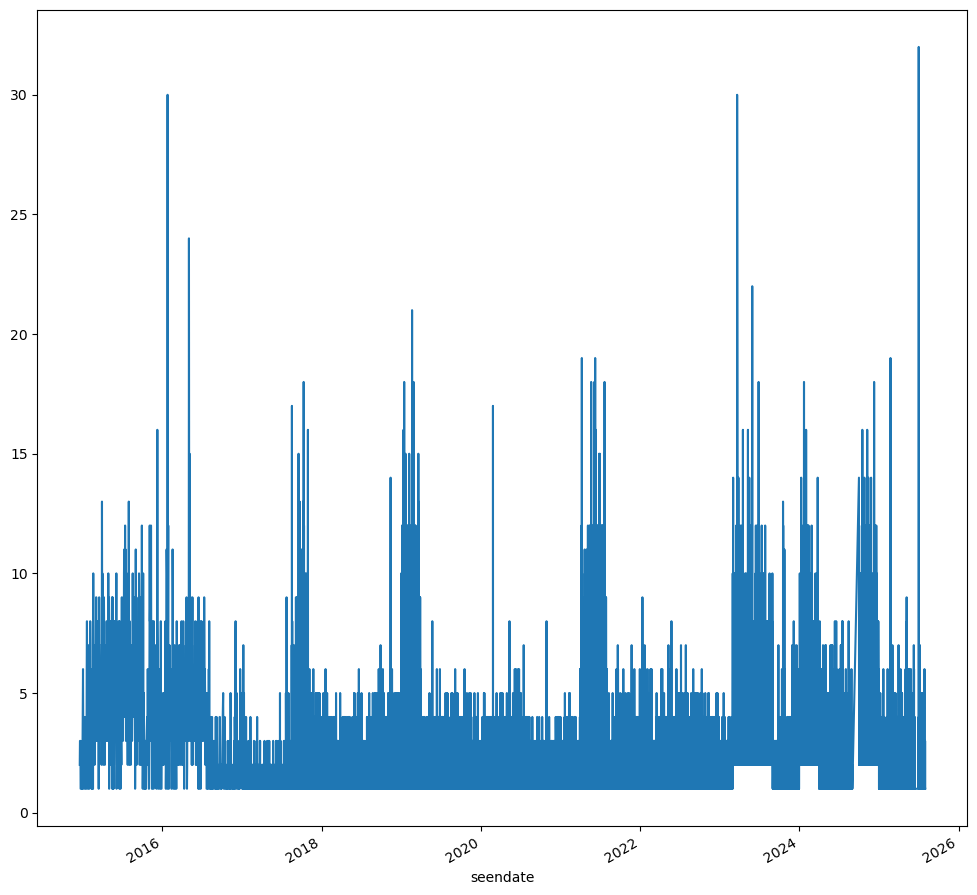

In [483]:
counts.plot(figsize = (12,12))

Mapping domain to news category

In [ ]:
domain_to_category = {
    # --- General ---
    "bbc.com": "general", "reuters.com": "general", "apnews.com": "general",
    "npr.org": "general", "aljazeera.com": "general", "theguardian.com": "general",
    "abcnews.go.com": "general", "cbsnews.com": "general", "nbcnews.com": "general",
    "usatoday.com": "general", "yahoo.com": "general", "voiceofamerica.com": "general",
    "dw.com": "general", "newsweek.com": "general", "news.com.au": "general",
    "scmp.com": "general", "japantimes.co.jp": "general",

    # --- Tech ---
    "techcrunch.com": "tech", "theverge.com": "tech", "arstechnica.com": "tech",
    "wired.com": "tech", "engadget.com": "tech", "gizmodo.com": "tech",
    "venturebeat.com": "tech", "mashable.com": "tech", "zdnet.com": "tech",
    "slashdot.org": "tech", "cnet.com": "tech", "techradar.com": "tech",
    "digitaltrends.com": "tech", "tomshardware.com": "tech",
    "pcmag.com": "tech", "androidauthority.com": "tech", "thenextweb.com": "tech",

    # --- Crypto ---
    "coindesk.com": "crypto", "cointelegraph.com": "crypto", "cryptonews.com": "crypto",
    "decrypt.co": "crypto", "theblock.co": "crypto", "beincrypto.com": "crypto",
    "bitcoinmagazine.com": "crypto", "cryptopotato.com": "crypto", "u.today": "crypto",
    "ambcrypto.com": "crypto", "cryptobriefing.com": "crypto", "cryptoslate.com": "crypto",
    "bitcoinist.com": "crypto", "btcmanager.com": "crypto", "cryptonewsz.com": "crypto",

    # --- Finance ---
    "investing.com": "finance", "marketwatch.com": "finance",
    "finance.yahoo.com": "finance", "fool.com": "finance",
    "seekingalpha.com": "finance", "fxstreet.com": "finance",
    "cnbc.com": "finance", "thestreet.com": "finance",
    "benzinga.com": "finance", "investopedia.com": "finance"
}

df = pd.read_csv("btc_full_gdelt.csv")

df["category"] = df["domain"].map(domain_to_category)

Cleaning the titles

In [ ]:
def clean_title(text):
    if not isinstance(text, str):
        return ""

    # basic cleanup
    text = text.strip()
    
    PREFIXES = ["update:", "breaking:", "exclusive:", "opinion:"]
    for p in PREFIXES:
        if text.lower().startswith(p):
            text = text[len(p):].strip()
    # normalize whitespace
    text = re.sub(r"\s+", " ", text)

    # remove HTML escape leftovers
    text = text.replace("&amp;", "&").replace("&nbsp;", " ")

    # remove trailing weird punctuation artifacts but keep normal punctuation
    text = re.sub(r"[\.]{3,}", "...", text)   # normalize long '...'

    # final lowercasing (optional but standard for ML)
    text = text.lower()

    return text

In [7]:
df["clean_title"] = df["title"].apply(clean_title)
df

,seendate,title,url,domain,topic,category,clean_title
0,2017-01-01 15:30:00+00:00,What Will the Bitcoin Price Be in 2017 ?,http://www.coindesk.com/what-will-the-bitcoin-...,coindesk.com,bitcoin,crypto,what will the bitcoin price be in 2017 ?
1,2017-01-01 22:45:00+00:00,"Bitcoin Price Tops $1 , 000 in First Day of 20...",http://www.coindesk.com/bitcoin-price-1000-jan...,coindesk.com,bitcoin,crypto,"bitcoin price tops $1 , 000 in first day of 20..."
2,2017-01-02 20:30:00+00:00,"With Bitcoin At $1000 , One Thing That Could S...",http://seekingalpha.com/article/4033803-bitcoi...,seekingalpha.com,bitcoin,finance,"with bitcoin at $1000 , one thing that could s..."
3,2017-01-02 21:30:00+00:00,"Bitcoin passes $1 , 000 amid growing acceptanc...",http://www.cbsnews.com/news/bitcoin-passes-100...,cbsnews.com,bitcoin,general,"bitcoin passes $1 , 000 amid growing acceptanc..."
4,2017-01-02 14:15:00+00:00,"Bitcoin breaks $1 , 000 level , highest in mor...",http://finance.yahoo.com/news/bitcoin-breaks-1...,finance.yahoo.com,bitcoin,finance,"bitcoin breaks $1 , 000 level , highest in mor..."
...,...,...,...,...,...,...,...
94758,2022-06-30 22:00:00+00:00,Who Is the Mystery Crypto Queen on the Run Aft...,https://www.thestreet.com/investing/who-is-cry...,thestreet.com,bitcoin price,finance,who is the mystery crypto queen on the run aft...
94759,2022-11-23 20:30:00+00:00,Bitcoin : Why investors can consider revisitin...,https://ambcrypto.com/bitcoin-why-investors-ca...,ambcrypto.com,bitcoin price,crypto,bitcoin : why investors can consider revisitin...
94760,2022-04-29 22:45:00+00:00,UK Cyber Cops Gladly Join Crypto Firms for Dou...,https://u.today/uk-cyber-cops-gladly-join-cryp...,u.today,crypto regulation,crypto,uk cyber cops gladly join crypto firms for dou...
94761,2022-05-24 14:15:00+00:00,Ripple CEO in Talks with Georgia Prime Ministe...,https://u.today/ripple-ceo-in-talks-with-georg...,u.today,crypto regulation,crypto,ripple ceo in talks with georgia prime ministe...


Instantiating the RoBERTa model

In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def batched_roberta_sentiment(texts, batch_size=64):
    all_scores = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]

        enc = tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            padding=True
        ).to(device)

        with torch.no_grad():
            logits = model(**enc).logits
            probs = logits.softmax(dim=1).cpu().numpy()

        compound = probs[:,2] - probs[:,0]  # pos - neg
        all_scores.append(compound)

    return np.concatenate(all_scores)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Running sentiment with RoBERTa

In [13]:
titles = df["clean_title"].tolist()
df["sent_roberta"] = batched_roberta_sentiment(titles, batch_size=64)

100%|██████████| 1481/1481 [1:15:17<00:00,  3.05s/it]


In [ ]:
df.head()

,seendate,title,url,domain,topic,category,clean_title,sent_roberta
0,2017-01-01 15:30:00+00:00,What Will the Bitcoin Price Be in 2017 ?,http://www.coindesk.com/what-will-the-bitcoin-...,coindesk.com,bitcoin,crypto,what will the bitcoin price be in 2017 ?,0.010540
1,2017-01-01 22:45:00+00:00,"Bitcoin Price Tops $1 , 000 in First Day of 20...",http://www.coindesk.com/bitcoin-price-1000-jan...,coindesk.com,bitcoin,crypto,"bitcoin price tops $1 , 000 in first day of 20...",0.429257
2,2017-01-02 20:30:00+00:00,"With Bitcoin At $1000 , One Thing That Could S...",http://seekingalpha.com/article/4033803-bitcoi...,seekingalpha.com,bitcoin,finance,"with bitcoin at $1000 , one thing that could s...",0.174980
3,2017-01-02 21:30:00+00:00,"Bitcoin passes $1 , 000 amid growing acceptanc...",http://www.cbsnews.com/news/bitcoin-passes-100...,cbsnews.com,bitcoin,general,"bitcoin passes $1 , 000 amid growing acceptanc...",0.426420
4,2017-01-02 14:15:00+00:00,"Bitcoin breaks $1 , 000 level , highest in mor...",http://finance.yahoo.com/news/bitcoin-breaks-1...,finance.yahoo.com,bitcoin,finance,"bitcoin breaks $1 , 000 level , highest in mor...",0.806844
...,...,...,...,...,...,...,...,...
94758,2022-06-30 22:00:00+00:00,Who Is the Mystery Crypto Queen on the Run Aft...,https://www.thestreet.com/investing/who-is-cry...,thestreet.com,bitcoin price,finance,who is the mystery crypto queen on the run aft...,-0.221500
94759,2022-11-23 20:30:00+00:00,Bitcoin : Why investors can consider revisitin...,https://ambcrypto.com/bitcoin-why-investors-ca...,ambcrypto.com,bitcoin price,crypto,bitcoin : why investors can consider revisitin...,0.031881
94760,2022-04-29 22:45:00+00:00,UK Cyber Cops Gladly Join Crypto Firms for Dou...,https://u.today/uk-cyber-cops-gladly-join-cryp...,u.today,crypto regulation,crypto,uk cyber cops gladly join crypto firms for dou...,0.440152
94761,2022-05-24 14:15:00+00:00,Ripple CEO in Talks with Georgia Prime Ministe...,https://u.today/ripple-ceo-in-talks-with-georg...,u.today,crypto regulation,crypto,ripple ceo in talks with georgia prime ministe...,0.083291


How does the sentiment look?

array([[<Axes: title={'center': 'sent_roberta'}>]], dtype=object)

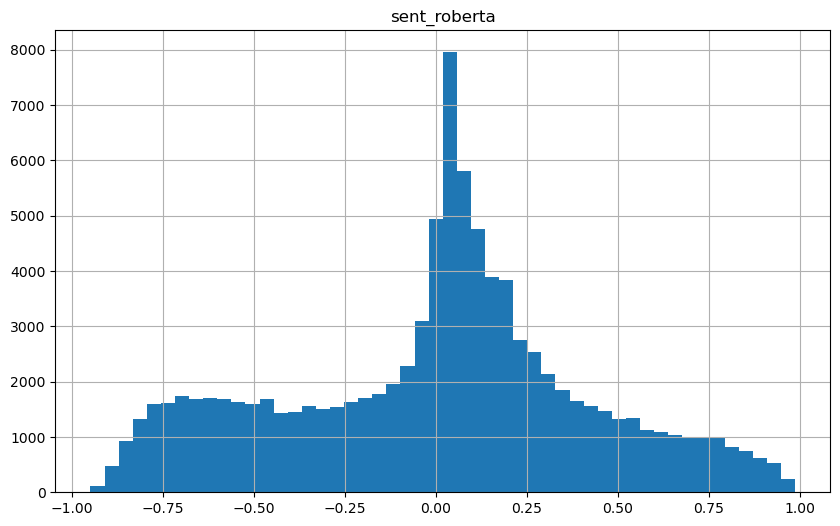

In [15]:
df.hist("sent_roberta", bins=50, figsize=(10,6))

Instantiating FinBERT

In [ ]:
# -----------------------------
# Load FinBERT (ProsusAI/finbert)
# -----------------------------
finbert_name = "ProsusAI/finbert"
finbert_tok = AutoTokenizer.from_pretrained(finbert_name)
finbert_model = AutoModelForSequenceClassification.from_pretrained(finbert_name)
finbert_model.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finbert_model.to(device)


# -----------------------------
# Batched FinBERT Scoring w/ tqdm
# -----------------------------
def score_finbert_batched(texts, batch_size=64):
    all_scores = []

    for i in tqdm(range(0, len(texts), batch_size), desc="FinBERT sentiment"):
        batch = texts[i:i+batch_size]

        # Tokenize
        enc = finbert_tok(
            batch,
            truncation=True,
            padding=True,
            return_tensors="pt"
        ).to(device)

        # Forward pass
        with torch.no_grad():
            logits = finbert_model(**enc).logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()

        # FinBERT output order: [negative, neutral, positive]
        compound = probs[:, 2] - probs[:, 0]
        all_scores.append(compound)

    return np.concatenate(all_scores)


Running the model and examining histogram

FinBERT sentiment: 100%|██████████| 1481/1481 [1:20:38<00:00,  3.27s/it]


array([[<Axes: title={'center': 'sent_finbert'}>]], dtype=object)

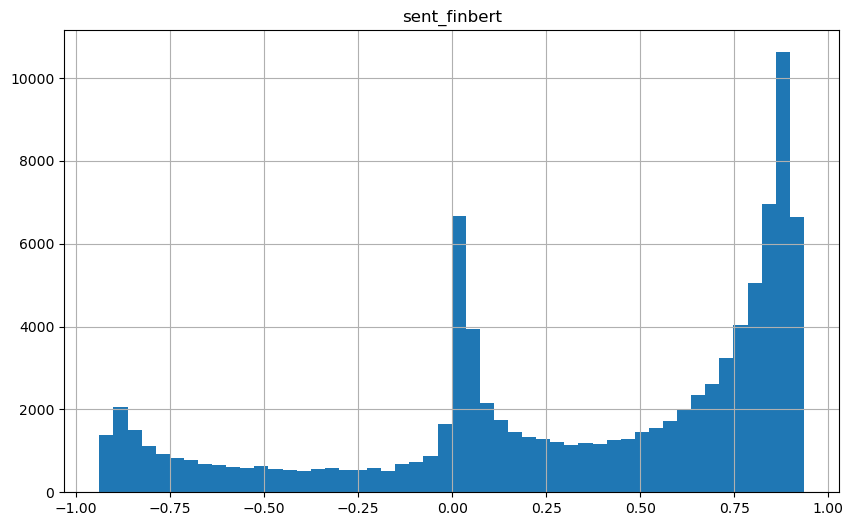

In [11]:
titles = df["clean_title"].tolist()
df["sent_finbert"] = score_finbert_batched(titles, batch_size=64)
df.hist("sent_finbert", bins=50, figsize=(10,6))

In [ ]:
df["date"] = pd.to_datetime(df["seendate"], errors="coerce")
df["date"] = df["date"].dt.date
df.drop(columns=["seendate"], inplace=True)

In [ ]:
df.head()

,title,url,domain,topic,category,clean_title,sent_finbert,sent_roberta,date
0,What Will the Bitcoin Price Be in 2017 ?,http://www.coindesk.com/what-will-the-bitcoin-...,coindesk.com,bitcoin,crypto,what will the bitcoin price be in 2017 ?,0.903834,0.010540,2017-01-01
1,"Bitcoin Price Tops $1 , 000 in First Day of 20...",http://www.coindesk.com/bitcoin-price-1000-jan...,coindesk.com,bitcoin,crypto,"bitcoin price tops $1 , 000 in first day of 20...",0.319665,0.429257,2017-01-01
2,"With Bitcoin At $1000 , One Thing That Could S...",http://seekingalpha.com/article/4033803-bitcoi...,seekingalpha.com,bitcoin,finance,"with bitcoin at $1000 , one thing that could s...",-0.497435,0.174980,2017-01-02
3,"Bitcoin passes $1 , 000 amid growing acceptanc...",http://www.cbsnews.com/news/bitcoin-passes-100...,cbsnews.com,bitcoin,general,"bitcoin passes $1 , 000 amid growing acceptanc...",-0.912445,0.426420,2017-01-02
4,"Bitcoin breaks $1 , 000 level , highest in mor...",http://finance.yahoo.com/news/bitcoin-breaks-1...,finance.yahoo.com,bitcoin,finance,"bitcoin breaks $1 , 000 level , highest in mor...",-0.517664,0.806844,2017-01-02
...,...,...,...,...,...,...,...,...,...
94758,Who Is the Mystery Crypto Queen on the Run Aft...,https://www.thestreet.com/investing/who-is-cry...,thestreet.com,bitcoin price,finance,who is the mystery crypto queen on the run aft...,0.379170,-0.221500,2022-06-30
94759,Bitcoin : Why investors can consider revisitin...,https://ambcrypto.com/bitcoin-why-investors-ca...,ambcrypto.com,bitcoin price,crypto,bitcoin : why investors can consider revisitin...,0.878218,0.031881,2022-11-23
94760,UK Cyber Cops Gladly Join Crypto Firms for Dou...,https://u.today/uk-cyber-cops-gladly-join-cryp...,u.today,crypto regulation,crypto,uk cyber cops gladly join crypto firms for dou...,0.835643,0.440152,2022-04-29
94761,Ripple CEO in Talks with Georgia Prime Ministe...,https://u.today/ripple-ceo-in-talks-with-georg...,u.today,crypto regulation,crypto,ripple ceo in talks with georgia prime ministe...,0.729238,0.083291,2022-05-24


Aggregating by date and category

In [82]:
# Group by date and category (e.g., 'general', 'finance', 'crypto', 'tech')
agg = df.groupby(['date', 'category']).agg({
    'sent_roberta': 'mean',
    'sent_finbert': 'mean',  # only if FinBERT exists
    # Add other models if needed
}).reset_index()

Saving the aggregated df

In [84]:
agg.to_csv("btc_full_gdelt_sentiment_raw.csv", index=False)

In [85]:
agg

,date,category,sent_roberta,sent_finbert
0,2014-12-18,crypto,0.275980,0.570879
1,2014-12-18,tech,0.175723,0.065022
2,2014-12-19,crypto,0.176350,0.904606
3,2014-12-19,tech,-0.244848,0.326561
4,2014-12-21,crypto,-0.181040,0.611405
...,...,...,...,...
11165,2025-07-30,finance,0.263527,0.081467
11166,2025-07-30,general,0.018191,-0.357018
11167,2025-07-31,finance,0.016990,0.246220
11168,2025-07-31,general,0.664661,0.763404


Mapping category weights to the dataset

In [86]:
weights = {
    'general': 0.4,
    'finance': 0.25,
    'tech': 0.25,
    'crypto': 0.10
}

agg['weight'] = agg['category'].map(weights)


Examining the individual sentiments by category for RoBERTa and FinBERT

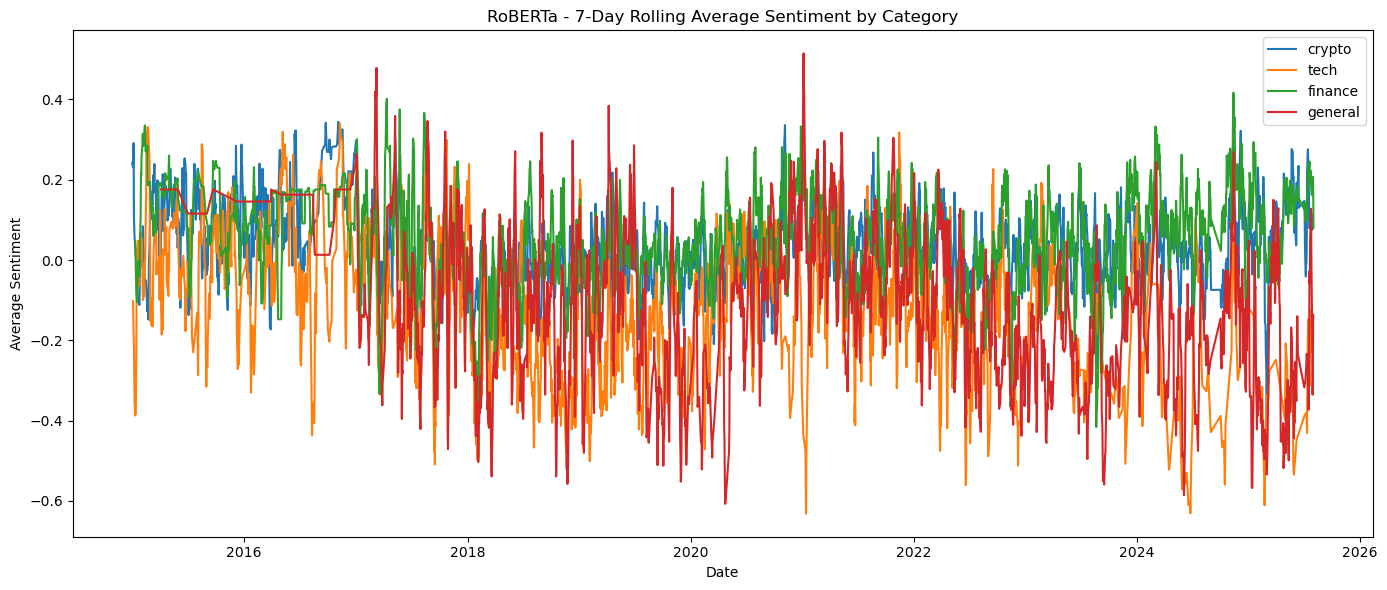

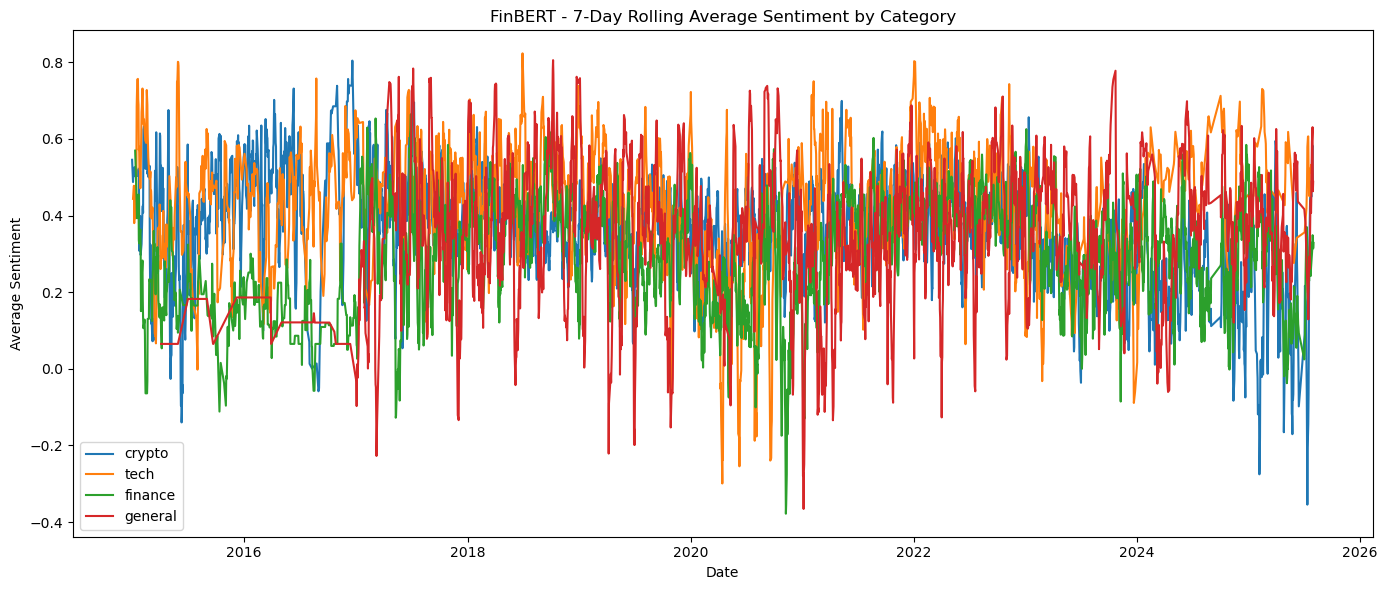

In [ ]:
# Ensure 'date' is datetime and sorted
agg['date'] = pd.to_datetime(agg['date'])
agg = agg.sort_values('date')

# Plot 1: RoBERTa with 7-day rolling mean
fig, ax1 = plt.subplots(figsize=(14, 6))
for category in agg['category'].unique():
    daily = (
        agg[agg['category'] == category]
        .groupby('date')['sent_roberta']
        .mean()
        .rolling(7)
        .mean()
        .reset_index()
    )
    ax1.plot(daily['date'], daily['sent_roberta'], label=category)

ax1.set_title('RoBERTa - 7-Day Rolling Average Sentiment by Category')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Sentiment')
ax1.legend()
plt.tight_layout()
plt.show()

# Plot 2: FinBERT with 7-day rolling mean
fig, ax2 = plt.subplots(figsize=(14, 6))
for category in agg['category'].unique():
    daily = (
        agg[agg['category'] == category]
        .groupby('date')['sent_finbert']
        .mean()
        .rolling(7)
        .mean()
        .reset_index()
    )
    ax2.plot(daily['date'], daily['sent_finbert'], label=category)

ax2.set_title('FinBERT - 7-Day Rolling Average Sentiment by Category')
ax2.set_xlabel('Date')
ax2.set_ylabel('Average Sentiment')
ax2.legend()
plt.tight_layout()
plt.show()

Creating the ensemble data

In [ ]:
agg["date"] = pd.to_datetime(agg["date"])

agg["roberta_z"] = (
    agg["sent_roberta"] - agg["sent_roberta"].mean()
) / agg["sent_roberta"].std()

agg["finbert_z"] = (
    agg["sent_finbert"] - agg["sent_finbert"].mean()
) / agg["sent_finbert"].std()

agg["ensemble_z"] = (
    0.7 * agg["finbert_z"] +
    0.3 * agg["roberta_z"]
)

z_min = agg["ensemble_z"].min()
z_max = agg["ensemble_z"].max()

agg["ensemble_scaled"] = 2 * (
    (agg["ensemble_z"] - z_min) / (z_max - z_min)
) - 1

daily_cat = (
    agg
    .groupby(["date", "category"], as_index=False)
    .agg(ensemble_scaled=("ensemble_scaled", "mean"))
)

Plotting the data now

Distributions of each category in the ensemble data

<Figure size 850x480 with 0 Axes>

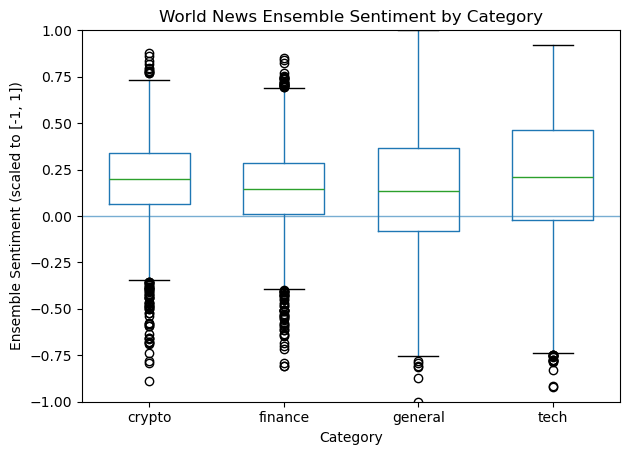

In [ ]:
plt.figure(figsize=(8.5, 4.8))

daily_cat.boxplot(
    column="ensemble_scaled",
    by="category",
    grid=False,
    widths=0.6
)

plt.title("World News Ensemble Sentiment by Category")
plt.suptitle("")
plt.xlabel("Category")
plt.ylabel("Ensemble Sentiment (scaled to [-1, 1])")
plt.axhline(0, linewidth=1, alpha=0.6)

plt.ylim(-1, 1)
plt.tight_layout()
plt.show()



Article count by year

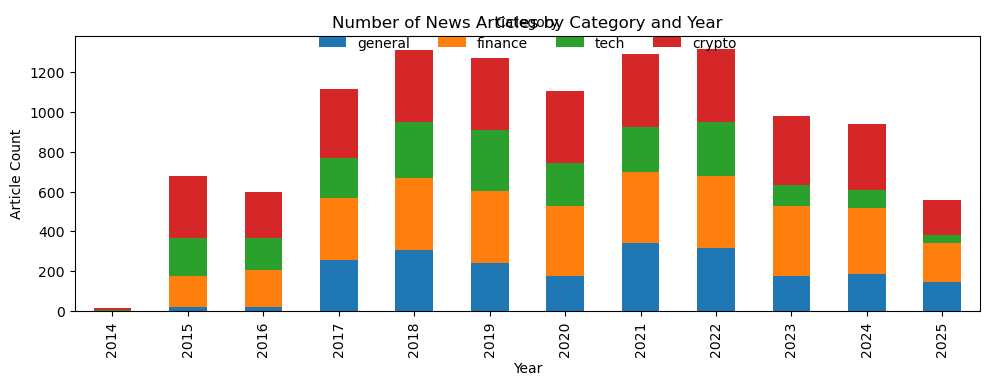

In [ ]:
# Ensure datetime
agg["date"] = pd.to_datetime(agg["date"])

# Count articles per year per category
yearly_counts = (
    agg
    .assign(year=agg["date"].dt.year)
    .groupby(["year", "category"])
    .size()
    .unstack(fill_value=0)
)

# Optional: consistent category order
cat_order = ["general", "finance", "tech", "crypto"]
yearly_counts = yearly_counts[[c for c in cat_order if c in yearly_counts.columns]]

yearly_counts.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 4.5)
)

plt.title("Number of News Articles by Category and Year")
plt.xlabel("Year")
plt.ylabel("Article Count")

plt.legend(
    title="Category",
    ncol=4,
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(0.5, 1.12)
)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

In [216]:
btc_close = pd.read_csv("data.csv")
btc_close["date"] = pd.to_datetime(btc_close["time"], errors="coerce").dt.date
btc_close = btc_close[["date", "PriceUSD_coinmetrics"]]
# btc_close = pd.DataFrame(btc_close)
btc_close

,date,PriceUSD_coinmetrics
0,2013-01-01,13.331371
1,2013-01-02,13.280607
2,2013-01-03,13.384081
3,2013-01-04,13.451721
4,2013-01-05,13.459407
...,...,...
4560,2025-06-27,107090.959051
4561,2025-06-28,107357.617171
4562,2025-06-29,108360.901696
4563,2025-06-30,107153.101136


How do the categories' sentiments change when the market sours?

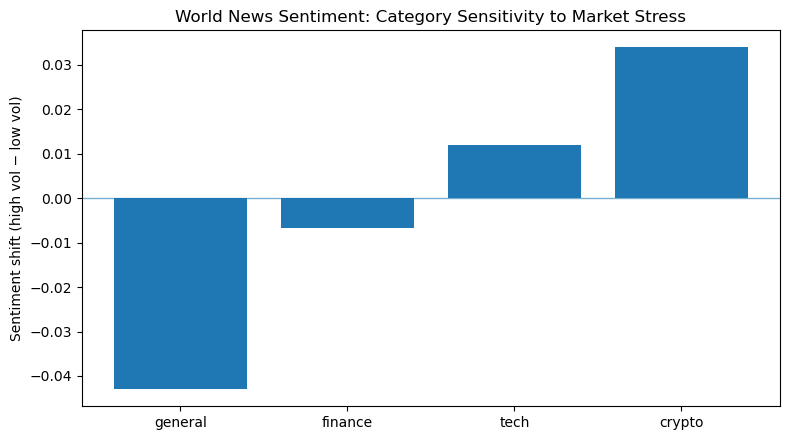

In [ ]:
btc_close = btc_close.copy()
btc_close["date"] = pd.to_datetime(btc_close["date"])
btc_close = (
    btc_close
    .set_index("date")["PriceUSD_coinmetrics"]
    .astype(float)
    .sort_index()
    .dropna()
)

# ---- 2) Returns + rolling vol ----
btc_ret = btc_close.pct_change()
vol = btc_ret.rolling(14).std()

# ---- 3) Prepare sentiment table ----
daily_cat["date"] = pd.to_datetime(daily_cat["date"])
tmp = daily_cat.merge(
    vol.rename("vol").reset_index().rename(columns={"index":"date"}),
    on="date",
    how="inner"
).dropna(subset=["vol", "ensemble_scaled"])

# ---- 4) Define regimes using quantiles computed on merged window ----
q_hi = tmp["vol"].quantile(0.67)
q_lo = tmp["vol"].quantile(0.33)

tmp["regime"] = "mid"
tmp.loc[tmp["vol"] >= q_hi, "regime"] = "high"
tmp.loc[tmp["vol"] <= q_lo, "regime"] = "low"

# ---- 5) Compute category shifts ----
shift = (
    tmp[tmp["regime"].isin(["high","low"])]
    .groupby(["category","regime"])["ensemble_scaled"]
    .mean()
    .unstack()
)

shift["delta"] = shift["high"] - shift["low"]
shift = shift.sort_values("delta")

# ---- 6) Plot ----
plt.figure(figsize=(8, 4.5))
plt.bar(shift.index.astype(str), shift["delta"])
plt.axhline(0, linewidth=1, alpha=0.6)
plt.ylabel("Sentiment shift (high vol − low vol)")
plt.title("World News Sentiment: Category Sensitivity to Market Stress")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



Plotting the final world sentiment

In [ ]:
# Step 2.1: Define and map category weights
category_weights = {
    'general': 0.40,
    'finance': 0.25,
    'tech': 0.25,
    'crypto': 0.10
}
agg['weight'] = agg['category'].map(category_weights)

df_long = agg.melt(
    id_vars=['date', 'category', 'weight'],
    value_vars=['sent_roberta', 'sent_finbert'],
    var_name='model',
    value_name='sentiment'
)
df_long
# df_long
# # df_long['model'] = df_long['model'].str.replace('sent_', '')

# Step 2.3: Weighted average per model per day
model_daily = (
    df_long
    .groupby(['model', 'date'])
    .apply(lambda x: (x['sentiment'] * x['weight']).sum() / x['weight'].sum())
    .reset_index(name='score')
)
model_daily
# model_daily.hist("score", bins=50, figsize=(10,6))


,date,category,weight,model,sentiment
0,2014-12-18,crypto,0.10,sent_roberta,0.275980
1,2014-12-18,tech,0.25,sent_roberta,0.175723
2,2014-12-19,crypto,0.10,sent_roberta,0.176350
3,2014-12-19,tech,0.25,sent_roberta,-0.244848
4,2014-12-21,crypto,0.10,sent_roberta,-0.181040
...,...,...,...,...,...
22335,2025-07-30,finance,0.25,sent_finbert,0.081467
22336,2025-07-30,general,0.40,sent_finbert,-0.357018
22337,2025-07-31,finance,0.25,sent_finbert,0.246220
22338,2025-07-31,general,0.40,sent_finbert,0.763404


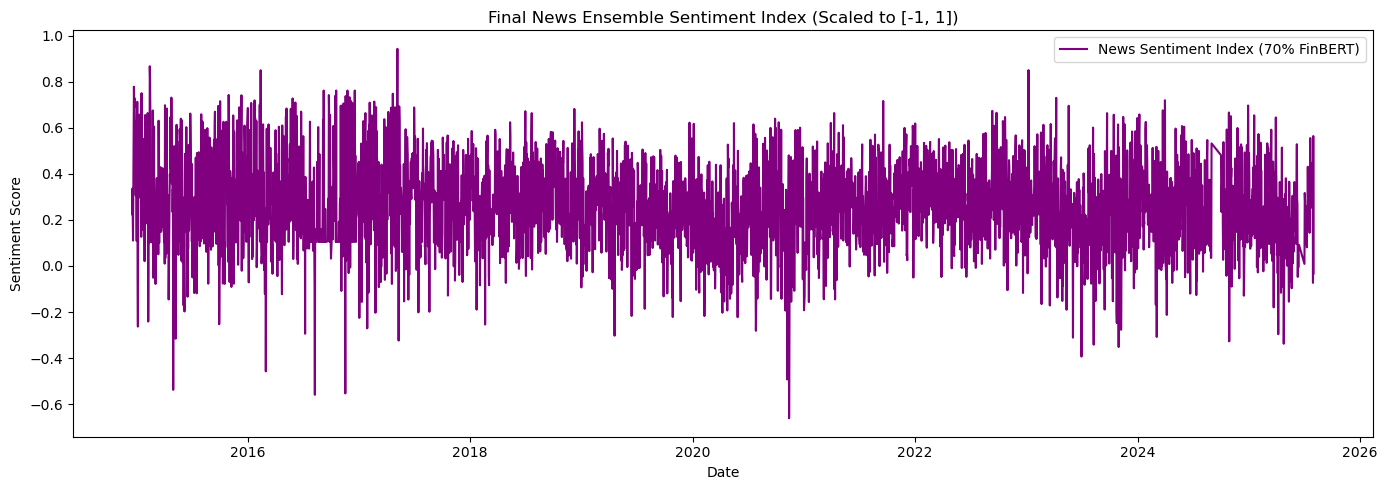

In [102]:
# Step 3.1: Clean model labels (optional if not done)
model_daily['model'] = model_daily['model'].str.replace('sent_', '')

# Step 3.2: Split by model
roberta = model_daily[model_daily['model'] == 'roberta'].copy()
finbert = model_daily[model_daily['model'] == 'finbert'].copy()

# Step 3.3: Normalize with min-max scaling to [-1, 1]
def minmax_scale(s):
    return (s - s.min()) / (s.max() - s.min()) * 2 - 1

roberta['scaled'] = minmax_scale(roberta['score'])
finbert['scaled'] = minmax_scale(finbert['score'])

# Step 3.4: Merge on date and compute ensemble
ensemble = pd.merge(
    roberta[['date', 'scaled']].rename(columns={'scaled': 'roberta_scaled'}),
    finbert[['date', 'scaled']].rename(columns={'scaled': 'finbert_scaled'}),
    on='date'
)

# Apply model weights (e.g., 70% FinBERT, 30% RoBERTa)
ensemble['ensemble'] = 0.7 * ensemble['finbert_scaled'] + 0.3 * ensemble['roberta_scaled']
ensemble = ensemble.sort_values('date')

# Step 3.5: Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(ensemble['date'], ensemble['ensemble'], color='purple', label='News Sentiment Index (70% FinBERT)')
plt.title('Final News Ensemble Sentiment Index (Scaled to [-1, 1])')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
world = pd.read_csv("btc_full_gdelt_sentiment_raw.csv")
world

,date,category,sent_roberta,sent_finbert
0,2014-12-18,crypto,0.275980,0.570879
1,2014-12-18,tech,0.175723,0.065022
2,2014-12-19,crypto,0.176350,0.904606
3,2014-12-19,tech,-0.244848,0.326561
4,2014-12-21,crypto,-0.181040,0.611405
...,...,...,...,...
11165,2025-07-30,finance,0.263527,0.081467
11166,2025-07-30,general,0.018191,-0.357018
11167,2025-07-31,finance,0.016990,0.246220
11168,2025-07-31,general,0.664661,0.763404


In [141]:
world.to_csv("btc_news_sentiment_final.csv", index=False)